<a href="https://colab.research.google.com/github/averyrop/AIM-Datathon/blob/main/Cancer_Survival_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project** **Title**: **Random forest for predicting patient survival**


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/MyDrive/aimdatathon/aimdatathon2020.zip

Archive:  gdrive/MyDrive/aimdatathon/aimdatathon2020.zip
  inflating: Background and Helpful Info.csv  
  inflating: Beverages.csv           
  inflating: Current Lifestyle.csv   
  inflating: DBBR Questionnaire Data Dictionary.csv  
  inflating: Exercise.csv            
  inflating: Family History.csv      
  inflating: Food Habits.csv         
  inflating: Foods.csv               
  inflating: Herbals.csv             
  inflating: Lifetime use of Supplements.csv  
  inflating: MedicalHistory.csv      
  inflating: MedicationUseHistory.csv  
  inflating: Multivitamins.csv       
  inflating: Nutrient Calc.csv       
  inflating: Smoking History.csv     
  inflating: Tumor Information_test.csv  
  inflating: Tumor Information_train.csv  
  inflating: Vitamins Minerals.csv   
  inflating: WomensHealth.csv        


### Data Management

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import plotly.express as px

In [ ]:
data_files = list(filter(lambda cont: 'csv' in cont,os.listdir()))

In [ ]:
#Get a list of all files as dataframes
All_files = {}
for fil in data_files:

    key = fil.split('.')[0]
    All_files[key]=(pd.read_csv(fil))
    
    All_files[key].rename(str.upper,axis='columns',inplace=True)
        

####Data Preprocessing

In [42]:
#Create a lambda function to help combine all dataframes
join_all = lambda df1,df2: df1.merge(right = df2, how = 'outer', on = 'QBARCODE' )                        

In [43]:
import functools

In [54]:
#Make a list of the Survey dataframes for use in reduce function
not_DBBR = list(filter(lambda f: 'DBBR' not in f,All_files.keys()))

Survey_list = []
for nam in All_files.keys():
  if nam in not_DBBR:
    Survey_list.append(All_files[nam])


In [56]:
#Combine all surveys into one, make a separate dataframe with the classes of the training set, so it can eventually be omitted from the dataframe of predictors
Combined_df = functools.reduce(join_all,Survey_list)

Class = pd.DataFrame(Combined_df[['QBARCODE','PATIENTSTATUS']])
barcs = pd.DataFrame(Combined_df['QBARCODE'])

In [58]:
#Want to be able to see how many patients for each column did not fill in an answer for the column.
#This loop only adds columns that have any null answers
#Because of the test train split two separate columns were made for answers that are in both, such as primary site x and y. These were not added because the columns being split make NAs appear
#Patient Status only exists for train and thus has nas for the train people, so it is also not being counted for this
#Make a list for columns with too many NAs, to omit.
#Make a list of columns with few NAs, to fill
omit = []
NA_dict = {}
NA_fill = []
for column in Combined_df:
    
    percent_null =  Combined_df[column].isnull().sum()/2000
    
    if percent_null != 0 and not ('x' in column or 'y' in column) and column != 'PATIENTSTATUS':
    
        NA_dict[column] = percent_null
        
        if percent_null > .3:
            omit.append(column)
        else:
            NA_fill.append(column)
        

In [60]:
#Drop columns with too many NAs
NA_dropped = Combined_df.drop(columns = omit)

#Take out class we're trying to predict
Class_dropped = NA_dropped.drop(columns = ['PATIENTSTATUS'])

In [61]:
#Make a dictionary so we can easily fill NAs in certain columns with mode of column
mode_list = [Class_dropped[col].mode()[0] for col in NA_fill ]
NA_fill_dict = dict(zip(NA_fill,mode_list))

In [62]:
#Fill NAs in specified columns
NA_filled = Class_dropped.fillna(value = NA_fill_dict)

In [63]:
#Find which columns have x and y in them in order to tell where the test/ train overlap happened. Turns out there were also multiple columns called iron and zinc.
#The iron and zinc ones are actually different though, so we don't need to do anythin with them

xy_list = sorted(list(filter(lambda col: ('x' in col or 'y' in col) ,NA_filled)))


In [64]:
#Make a list of the dataframes of the xys
xy_dfs = []
for col in xy_list:
    xy_dfs.append(pd.DataFrame(NA_filled[col]))

In [65]:
#Combine the x and y column into one column for the columns that are separated in the test/ train split

comb_test_train = pd.DataFrame(index = range(NA_filled.shape[0]))

for i in range(0,len(xy_dfs)-1, 2):
    
    col = xy_list[i]
    
    if 'IRON' not in col and 'ZINC' not in col:
        
        xy_dfs[i+1].columns = xy_dfs[i].columns
        
        comb_df = xy_dfs[i].combine_first(xy_dfs[i+1])
        
        comb_test_train = pd.concat([comb_test_train,comb_df],axis=1)
        

In [67]:
# Make list of columns in test and training surveys, to be omitted from overall dataframe
test_train_list = list(filter(lambda col: ('IRON' not in col and 'ZINC'not in col),xy_list))

In [68]:
# Drop desired columns from overall dataframe. Also record which Barcodes are test and train for easy merges later
Test_train_dropped = NA_filled.drop(test_train_list,axis='columns')
train_barcodes = pd.DataFrame(All_files['Tumor Information_train']['QBARCODE'])
test_barcodes =  pd.DataFrame(All_files['Tumor Information_test']['QBARCODE'])

In [69]:
#Make dataframe with combined test and train  data back in 

Full_pred = pd.concat([Test_train_dropped,comb_test_train],axis=1)

### Study Design


In [ ]:
#Here some of the demographics and proportions of the data with classes attached are explored here. 
#Only the class associated ones are looked at, as they influence the model created.

In [109]:
stud_des_df = train_barcodes.merge(Full_pred, on = 'QBARCODE').merge(Class,on='QBARCODE')

In [207]:
##This shows that 62% of the people in training data survived (1)

px.pie(data_frame = stud_des_df, names = 'PATIENTSTATUS',title = 'Survival breakdown')

In [121]:
#Pulling data for race breakdown
race_list = list(filter(lambda n: 'RAC' in n,list(stud_des_df.columns)))

race_df = stud_des_df[race_list]

In [202]:
#Still pulling data for race breakdown
racs = []
for row in race_df.iterrows():

  racs.append(list(row[1].index[row[1]==1]))

In [217]:
#Shows that 93% of participants were race 1 (White)
# 4.5% were Race 2 (Black)
# .625% Race 3 (American Indian/Alaskan Native)
# .438% Race 4 (Asian)
# .125% Race 5 (Native Hawaiian/other Pacific Islander)

px.pie(names = racs, title = 'Race breakdown')

/usr/local/lib/python3.6/dist-packages/plotly/express/_core.py:998: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [215]:
#Approximately normal distribution with a mean at about 62
#Blue shows living, red shows dead. The curve shape is about the same, showing
#That age basically doesn't affect the deaths
px.histogram(data_frame = stud_des_df, x = 'AGE',title = 'Age breakdown',color = 'PATIENTSTATUS')

In [259]:
#Organize survival and income data
inc_list = list(stud_des_df['HHINC'])

inc_dict = {1:'< 10k',2:'10k-25k',3:'25k-50k',4:'50k-75k',5:'> 75k',6:'Refuse to answer',77:'Don\'t know',99:'No response'}

inc_map = list(map(lambda ele: inc_dict[ele],inc_list))
stat_list = list(stud_des_df['PATIENTSTATUS'])

i_s_dict = {'inc' :inc_map,'stat' : stat_list}
inc_stat_df = pd.DataFrame(data = i_s_dict)


In [276]:
#Shows the incomes grouped based on survival(blue live, red die)
# As 60% of paitents lived itd make sense for blue to be higher, about 1.5x the height of the corresponding red
#This shows those who made under 25k were more likely to die, as the percentages of living to dead are mismatched 
px.histogram(data_frame=inc_stat_df, x = 'inc', color = 'stat', barmode = 'group')

###Train and Test Data Pre-processing

In [71]:
#Identify Data that's in training set
Full_pred_train = train_barcodes.merge(Full_pred, on = 'QBARCODE')

In [72]:
#identify data that needs encoding
str_list = []
for col in Full_pred:
    
    if Full_pred[col].dtype == 'O':
        
        str_list.append(col)
        

In [73]:
#Separate data that needs encoding
pre_enc = Full_pred[str_list]

In [74]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [75]:
#Encode string columns

oh_enc = OneHotEncoder().fit(pre_enc)

enc_names = oh_enc.get_feature_names()

enc = pd.DataFrame(oh_enc.transform(pre_enc).toarray(),columns = enc_names)

In [76]:
#Recombine encoded columns, and remove barcode so it doesn't get scaled in next block
enc_frame = pd.concat([Full_pred.drop(str_list,axis=1), enc],axis = 1)
enc_frame.drop('QBARCODE',axis=1,inplace=True)

In [77]:
#Scale values, so ML model can read data well
scale_fit = StandardScaler().fit(enc_frame)

scale_frame = pd.DataFrame(scale_fit.transform(enc_frame),columns = enc_frame.columns)

In [78]:
#Checking to see if columns are too homogenous. This would mean that most of the values in the column are the same. Current threshold is that if over 96% are the same
#then it gets added to list to omit

#This also acts to get rid of infrequent string answers, as they would have few binary 1s triggered in there individual column after encoding. Some of this information may be useful,
# like some cancer locations, but it would need transformation first. For example, Colon and Colon overlapping lesion could be both named colon, but this would take time that 
#I don't think I currently have.

homo = []

for col in scale_frame:
    
    most_freq = scale_frame[col].value_counts(True).values[0]
    
    if most_freq >.95:
        
        homo.append(col)
        

In [79]:
#Dataframe with homogeneous values pulled out
het_frame = scale_frame.drop(homo,axis=1)

In [80]:
#Associating barcodes with previous df
barc_het_frame = pd.concat([barcs,het_frame],axis=1)

In [81]:
#Pulling the data that has classes associated together
clean_train = train_barcodes.merge(barc_het_frame, on = 'QBARCODE')

In [82]:
#Pulling together said classes
train_class = train_barcodes.merge(Class, on = 'QBARCODE')

##Train-Validation Split

*   Use the a subset of the train to validate the model -> this is to create a validation(discrimination) performance (w/ AUC metric).



In [83]:
from sklearn.model_selection import train_test_split
from  sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [84]:
#Split data that has classes associated into test and training, so I can verify  acccuracy of model
X_train,X_test,y_train,y_test = train_test_split(clean_train,train_class,test_size=.2,random_state = 93048)

X_train.drop('QBARCODE', axis = 1, inplace = True)
X_test.drop('QBARCODE', axis = 1, inplace = True)
y_train.drop('QBARCODE', axis = 1, inplace = True)
y_test.drop('QBARCODE', axis = 1, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



##Model Training

In [85]:
#Do feature selection based on the outcomes of random forests with 200 trees
#RFECV uses all features, then starts eliminating features, based on the accuracy of a random forest model
#Fit with these features. It also uses 5 fold cross validation while doing this, to make sure there aren't weird splits when
#testing
log_selector = RFECV(estimator = RandomForestClassifier(200), step = 25,min_features_to_select = 25,n_jobs=-1).fit(X_train,np.ravel(y_train['PATIENTSTATUS']))

###Results_Model-Performance_and_Interpretability

In [87]:
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_roc_curve

In [88]:
y_hat = log_selector.predict(X_test)
y_score = log_selector.predict_proba(X_test)[:,1]

In [89]:
pd.DataFrame(confusion_matrix(y_test,y_hat))

,0,1
0,42,76
1,18,184


In [90]:
roc_auc_score(y_test,y_score)

0.7670750125860044

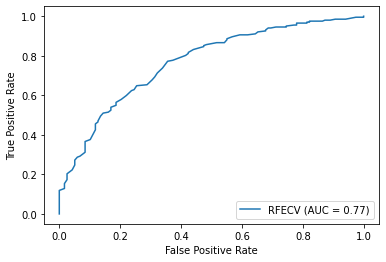

In [91]:
plot_roc_curve(log_selector,X_test,y_test)

### Feature Importance

In [92]:
#Get which columns are used for naming
log_sel_ind = log_selector.get_support()

In [93]:
#Selected Columns
sel_columns = list(X_train.columns[log_sel_ind])

In [102]:
#For finding which questions were important from the selected variable names
var_list = list(All_files['DBBR Questionnaire Data Dictionary']['VARNAME'])
up_var_list = [var.upper() for var in var_list]
quest_list = list(All_files['DBBR Questionnaire Data Dictionary']['VARIABLE'])

quest_dict = dict(zip(up_var_list,quest_list))

In [103]:
#Compiling important questions 

Sel_quests = []

for col in sel_columns:
    
    if 'x' in col or 'y' in col:
        
        co = col.split('_')[0]

    else:
        
        co = col
        
    try:
    
        Sel_quests.append(quest_list[up_var_list.index(co)])
        
    except:
        
        continue

In [105]:
#These are at least some of the questions used by the model to predict the patient class
Sel_quests

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'Current frequency of frying food ',
 'Current frequency of eating vegetables',
 'Current frequency of eating fruit',
 'Current days/wk  exercise 20+ minutes ',
 'Ever had a job that involved regular physical activity',
 'At what age began physically active job',
 'How many years worked physically active job',
 'Level of physical activity compared to others your age ',
 'Walk in past 10 years',
 'Years walked for exercise',
 'Days per week walked',
 'Minutes per day walked',
 'Usual pace walked',
 'Lift weights or weight machine in

##Create Submission File

In [98]:
#Now to predict the test set based on the selector
test_samples = test_barcodes.merge(barc_het_frame, on = 'QBARCODE')
test_samples.drop('QBARCODE', axis=1, inplace= True)

In [99]:
submission_preds = pd.DataFrame(log_selector.predict_proba(test_samples)[:,1], columns = ["PatientStatus"])

In [100]:
submission = pd.concat([test_barcodes, submission_preds], axis = 1 )
submission.columns = ['qbarcode',"PatientStatus"]

In [101]:
submission.to_csv('Good_submission.csv', index = False)

In [ ]:
##I don't know how to access the true class data from the kaggle competition, but the score on the public leaderbord
#From this redone project in a late submission was .75703